<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_all_in_sequence_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install -q talos

     |████████████████████████████████| 26.6MB 139kB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
pip install -q wget

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time
import sys

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


# from keras.layers import LSTM
# from keras.models import Sequential
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.core import Dense, Activation, Dropout
# from keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

import os
import wget
from zipfile import ZipFile

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [0]:
# from keras.optimizers import Adam, Nadam
# from keras.activations import softmax
# from keras.losses import categorical_crossentropy, logcosh
# from talos.utils import lr_normalizer
import talos
from tensorflow.python.keras.optimizers import Adam, Nadam
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.losses import categorical_crossentropy, logcosh
from talos.utils import lr_normalizer

In [92]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.3.0
1.15.2


In [93]:
#Flag to select the small or the large dataset from the git repo
large=False;

if not large:
  #Small Dataset
  #Data import from git repo
  print("Small Dataset Loading")
  url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
  #df1 = pd.read_csv(url, error_bad_lines=False)
  dfstocks = pd.read_csv(url, sep=',')
  dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
else:
  #Large Dataset
  print("Large Dataset Loading")
  url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined_large.zip'
  wget.download(url, '.')
  # Create a ZipFile Object and load sample.zip in it
  with ZipFile('combined_large.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
  print(os.listdir("."))
  dfstocks = pd.read_csv('combined_large.csv', sep=',') 
  dfstocks=dfstocks[~dfstocks.Date.str.contains("nan")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("Low")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("N/A")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("date")]
  dfstocks.Date=pd.to_datetime(dfstocks.Date)
  # dfstocks['Date'] = dfstocks['Date'].dt.strftime('%Y-%m-%d')
  dfstocks['Date'] = dfstocks['Date'].dt.strftime('%d-%m-%Y')
  dfstocks=dfstocks.rename({' AA':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);

Small Dataset Loading


In [94]:
type(dfstocks['Date'])
dfstocks.dtypes

Date       object
Close      object
Volume     object
Open       object
High       object
Low        object
Company    object
dtype: object

In [95]:
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [96]:
dfstocks

,Date,Close,Volume,Open,High,Low,Company
0,12/31/2019,$293.65,25247630,$289.93,$293.68,$289.52,AAPL
1,12/30/2019,$291.52,36059610,$289.46,$292.69,$285.22,AAPL
2,12/27/2019,$289.8,36592940,$291.12,$293.97,$288.12,AAPL
3,12/26/2019,$289.91,23334000,$284.82,$289.98,$284.7,AAPL
4,12/24/2019,$284.27,12119710,$284.69,$284.89,$282.9197,AAPL
...,...,...,...,...,...,...,...
229381,02/22/2010,$65.4,20454080,$66.1,$66.12,$65.25,XOM
229382,02/19/2010,$65.87,24264350,$65.59,$66.24,$65.43,XOM
229383,02/18/2010,$65.96,22534130,$65.8,$66.09,$65.35,XOM
229384,02/17/2010,$65.76,21802100,$66.34,$66.45,$65.57,XOM


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [98]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [99]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [100]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [101]:
dfstocks.Company.unique()

array([' AAPL', ' ABBV', ' ABT', ' ACN', ' ADBE', ' AGN', ' AIG', ' ALL',
       ' AMGN', ' AMZN', ' AXP', ' BA', ' BAC', ' BIIB', ' BK', ' BKNG',
       ' BLK', ' BMY', ' C', ' CAT', ' CHTR', ' CL', ' CMCSA', ' COF',
       ' COP', ' COST', ' CSCO', ' CVS', ' CVX', ' DHR', ' DIS', ' DUK',
       ' EMR', ' EXC', ' F', ' FB', ' FDX', ' GD', ' GE', ' GILD',
       ' GOOGL', ' GS', ' HD', ' HON', ' IBM', ' INTC', ' JNJ', ' JPM',
       ' KMI', ' KO', ' LLY', ' LMT', ' LOW', ' MA', ' MCD', ' MDLZ',
       ' MDT', ' MET', ' MMM', ' MO', ' MRK', ' MS', ' MSFT', ' NEE',
       ' NFLX', ' NKE', ' NVDA', ' ORCL', ' OXY', ' PEP', ' PFE', ' PG',
       ' PM', ' QCOM', ' RTN', ' SBUX', ' SLB', ' SO', ' SPG', ' T',
       ' TGT', ' TMO', ' TXN', ' UNH', ' UNP', ' UPS', ' USB', ' UTX',
       ' WBA', ' WMT', ' XOM', ' GOOG', ' DD', ' KHC', ' PYPL', ' DOW'],
      dtype=object)

In [0]:
#Company Chosen
comp="AAPL"

In [103]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains(comp)]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

2487

In [0]:
#Run only if you want to have a subset hidden from talos
#hidden split for validation
talos=False;

if talos:
  hidden_split=sub_split[(sub_split['Date'].dt.year==2018) | (sub_split['Date'].dt.year==2017) | (sub_split['Date'].dt.year==2016)]

  #drop hidden_split from sub_split 
  sub_split=sub_split[sub_split['Date'].dt.year < 2016]
  hidden_split

In [105]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,29.0571,135631411,28.8486,29.0986,28.7886,AAPL
1,2010-02-17,28.9357,108691903,29.1700,29.1871,28.6943,AAPL
2,2010-02-18,28.9897,105298302,28.8043,29.1271,28.7028,AAPL
3,2010-02-19,28.8100,103810451,28.8371,29.0286,28.7300,AAPL
4,2010-02-22,28.6308,97607889,28.9057,28.9286,28.4557,AAPL
...,...,...,...,...,...,...,...
2482,2019-12-24,284.2700,12119710,284.6900,284.8900,282.9197,AAPL
2483,2019-12-26,289.9100,23334000,284.8200,289.9800,284.7000,AAPL
2484,2019-12-27,289.8000,36592940,291.1200,293.9700,288.1200,AAPL
2485,2019-12-30,291.5200,36059610,289.4600,292.6900,285.2200,AAPL


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])
    series3 = pd.Series(time_series[time_series.columns[2]])
    series4 = pd.Series(time_series[time_series.columns[3]])
    series5 = pd.Series(time_series[time_series.columns[4]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))
    values3 = series3.values
    values3 = values3.reshape((len(values3), 1))
    values4 = series4.values
    values4 = values4.reshape((len(values4), 1))
    values5 = series5.values
    values5 = values5.reshape((len(values5), 1))

    #scaler2 --> Close Price Scaler
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)
    scaler3 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled3"]= scaler3.fit_transform(values3)
    scaler4 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled4"]= scaler4.fit_transform(values4)
    scaler5 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled5"]= scaler5.fit_transform(values5)


    time_series = time_series[["scaled1","scaled2","scaled3","scaled4","scaled5"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)-1]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [0]:
#mounting gdrive to save talos results for each run and tensor flow checkpoints
mounted = True
if not mounted:
  from google.colab import drive
  drive.mount('/content/gdrive')

In [0]:
#def get_seq_model(hidden_units1=40, hidden_units2=65, hidden_units3=32, drop=0.2,input_shape=(1,1)):
def get_seq_model(x_train, y_train, x_val, y_val, params):  

    # create and fit the LSTM network
    model = Sequential()

    print(params)
    print(type(params))

    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227222

    ######!!!!!#####!!!!!
    #(train_x.shape[1],5) where 5 is the number of features is equal to :
    #(train_x.shape[1],train_x.shape[2])
    model.add(LSTM(
                   input_shape=(x_train.shape[1],x_train.shape[2]),
                   units = params['hidden_1'],  
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(
                   units = params['hidden_2'],
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))   
    model.add(LSTM(
                   units = params['hidden_3'], 
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
   # model.add(TimeDistributed(Dense(5)))
    model.add(TimeDistributed(Dense(5)))
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_path = "/content/gdrive/My Drive/checkpoints2"  + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,#save_best_only='TRUE'
        # Save weights, every 5-epochs.
        period=15)
    
   # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
    
    out = model.fit(x_train, y_train,
              epochs=params['epochs'], batch_size=1,
              validation_data=[x_val, y_val],
              #epochs=200, batch_size=1,
              verbose=1,shuffle=False,
              callbacks=[cp_callback])

    return out, model

In [0]:
# ls gdrive/"My Drive"/checkpoints1

In [0]:
talos=False;

if not talos:
  #Chosen final parameters
  p = {'hidden_1': 8,
     'hidden_2': 16,
     'hidden_3': 32,
     'dropout': 0.1,
     'epochs': 100
     }

else:
  #Parameters for the model optimization in talos
  p = {'hidden_1':[8, 16, 32],
     'hidden_2':[8, 16, 32],
     'hidden_3':[8, 16, 32],
     'dropout': [0.1, 0.2],
     #'dropout': [0.1],
     'epochs': [20, 50, 100]
     }

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close', 'Open', 'High', 'Low']]
#sub_split.columns[1]

In [112]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
# print(train)

1740
1740
(1740, 5)
(746, 5)


In [113]:
#We use numpy to reshape our time series into 3D tensors.
# train = np.reshape(train,(train.shape[0],1,5))
# test = np.reshape(test,(test.shape[0],1,5))

train = np.reshape(train,(1,train.shape[0],5))
test = np.reshape(test,(1,test.shape[0],5))


# train_x = train[:,:,:]
# train_y = train[:,:,:]

# test_x = test[:,:,:]
# test_y = test[:,:,:]

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]
test_x = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')
test_y = pad_sequences(test_y,maxlen=train_y.shape[1],padding='post',dtype='float64')
print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 5)
train_y shape=(1, 1739, 5)
test_x shape=(1, 1739, 5)
test_y shape=(1, 1739, 5)


In [114]:
load_from_checkpoint=False;

seq_lstm_model=None
if load_from_checkpoint:
  #Load the latest checkpoint saved in Drive #'gdrive/My Drive/checkpoints1/cp-0090.ckpt'
  ####
  latest=tf.train.latest_checkpoint("gdrive/My Drive/checkpoints2")
  print(latest)
  #Create the model and train for 1 epoch to get the NN stracture
  p['epochs']=1
  try:
    seq_lstm_model=get_seq_model(train_x,train_y,test_x,test_y,p)
  except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)
  #Load the weight of the checkpoint to the NN 
  seq_lstm_model[1].load_weights(latest)
else:
  # build RNN model and run 100 epochs
  p['epochs']=20
  try:
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)
  except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)

{'hidden_1': 8, 'hidden_2': 16, 'hidden_3': 32, 'dropout': 0.1, 'epochs': 20}
<class 'dict'>


Train on 1 samples, validate on 1 samples
Epoch 1/20
1/1 [==============================] - 6s 6s/sample - loss: 0.0587 - val_loss: 0.1213
Epoch 2/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0466 - val_loss: 0.1088
Epoch 3/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0397 - val_loss: 0.0972
Epoch 4/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0334 - val_loss: 0.0852
Epoch 5/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0272 - val_loss: 0.0725
Epoch 6/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0215 - val_loss: 0.0596
Epoch 7/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0163 - val_loss: 0.0477
Epoch 8/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0121 - val_loss: 0.0381
Epoch 9/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0094 - val_loss: 0.0323
Epoch 10/20
1/1 [==============================] - 3s 3s/sample - loss: 0.0079 - val_

In [0]:
# x=np.concatenate((train_x, test_x), axis=1)
# y=np.concatenate((train_y, test_y), axis=1)
# print("x shape={}".format(x.shape))
# print("y shape={}".format(y.shape))
# import talos
# 

In [0]:
%%capture
talos=False;
if talos:
  import talos
  # 100	0.0005776109765	0.001970537574	0.1	100	8	16	32
  scan_obj = talos.Scan(x=train_x,
                        y=train_y,
                        x_val=test_x,
                        #x_val=train_x,
                        y_val=test_y,
                      #y_val=train_y,

                        params=p,
                        val_split=0.1,
                        model=get_seq_model,
                        #shuffle=False,
                        experiment_name='gdrive/My Drive/test',
                        #fraction_limit=0.1
                        )


In [0]:
if talos:
  print("Finished Talos Scan!!")

In [0]:
if talos:
  scan_obj.data.head()

In [0]:
# train_y

In [0]:
# train the model
#https://medium.com/@rajath95/how-to-save-and-upload-deep-learning-machine-learning-models-in-google-colab-using-google-drive-eb2901937ae
# seq_lstm_model[1].fit(train_x, train_y,
#                 epochs=2, batch_size=1,
#                 #epochs=200, batch_size=1,
#                 verbose=1)
# print("Model Fit Complete")

In [121]:
# train fit performance
trainPredict = seq_lstm_model[1].predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

# forecast values
testPredict = seq_lstm_model[1].predict(testPredict)
testPredict

Train Score: 0.07 RMSE


array([[[0.02721794, 0.00864802, 0.0224762 , 0.02542598, 0.0163686 ],
        [0.03627729, 0.01134241, 0.03077019, 0.03834353, 0.02302258],
        [0.0440458 , 0.01769863, 0.03978113, 0.05059626, 0.03156172],
        ...,
        [0.13398954, 0.05066279, 0.07267582, 0.09099662, 0.04893447],
        [0.13398954, 0.05066279, 0.07267582, 0.09099662, 0.04893447],
        [0.13398954, 0.05066279, 0.07267582, 0.09099662, 0.04893447]]],
      dtype=float32)

In [0]:
# print()

In [0]:
# trainPredict

In [0]:
# # forecast values
# testPredict = seq_lstm_model[1].predict(testPredict)
# testPredict

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, [2,3,4], 2)
trainPredict=np.delete(trainPredict, [2,3,4], 2)

testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

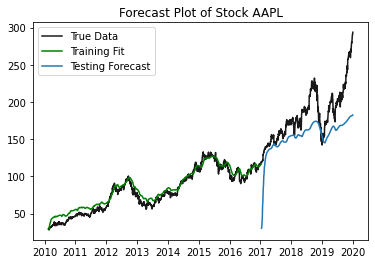

In [137]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.9,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

plt.plot(sub_split_date.Date[split_ratio+1:],
           testPredict[:test_x.shape[1]-993],label='Testing Forecast')

#plt.plot(sub_split_date.Date[split_ratio+2:],
#          testPredict[:test_x],label='Testing Forecast')

plt.title('Forecast Plot of Stock ' + comp)
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()